# Wind visualization

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
from scipy.interpolate import griddata

import sys
sys.path.append('../../../AsymptoticSolver/')
sys.path.append('..')

from Utilities.coord_func import cart2pol
from Utilities.add_var import add_u_polar, get_bg_wind
from AsymptoticSolver import polar_dft, polar_idft, pick_fourier_comp

%matplotlib notebook

### 1. Get data

Initial data is taken from NARVAL simulation for the 17.08.2016 1200 UTC (initialized at 0000 UTC).
Center is calculated with method of centroid pressure.


__Constants:__  
lev_start: Level from where the calculation should start  
km: Radius around the cyclone center  
r_earth: Radius of earth  
r_rad: Radius around the cyclone center in radians

In [3]:
lev_start= 45             
km       = 250                           
r_earth  = 6371                     
r_rad    = km / r_earth

In [4]:
# Data for centerline
center_file       = "../Data/center_fiona.npy" 
center = np.load(center_file)
x_center = center[:,0]
y_center = center[:,1]


# Initial data
ds_orig = xr.open_dataset('../../../../init_data/dei4_NARVALII_2016081700_fg_DOM01_ML_0012.nc')

u = ds_orig.u[0]
v = ds_orig.v[0]

ds_orig = add_u_polar(ds_orig, u, v, center)

# Number of levels in file (highest index is lowest level -> p-system)
nlev = len(ds_orig.height.values)
height = ds_orig.z_ifc.values


Calculate u_r and u_phi for following levels: 8229.29 to 0.0


Extract u and v seperately to calculate the background wind from them. The region from which the mean is used as background is based on the results of a sensitivity study. There the average wind speed for different regions has been compared.


In [5]:
bg_wind = get_bg_wind(ds_orig)

# Get wind without background
nobg_u = ds_orig.u[0].copy()
nobg_v = ds_orig.v[0].copy()

for i in range(0,nlev):
    nobg_u[i] = nobg_u[i] - bg_wind[0][i]
    nobg_v[i] = nobg_v[i] - bg_wind[1][i]

In [6]:
print(nobg_u) 
ds_orig.u.values[0]

<xarray.DataArray 'u' (height: 75, ncells: 2469998)>
array([[15.670204  , 15.640554  , 15.621634  , ..., -1.7276573 ,
        -1.7306404 , -1.7207489 ],
       [10.203612  , 10.19124   , 10.189134  , ...,  0.63557816,
         0.62376213,  0.6287823 ],
       [ 7.8859854 ,  7.885868  ,  7.8752184 , ..., -4.737875  ,
        -4.6260376 , -4.5757923 ],
       ...,
       [ 2.7432761 ,  2.7233531 ,  2.7268953 , ...,  0.18911552,
         0.18615007,  0.1985724 ],
       [ 2.6425989 ,  2.623503  ,  2.6273093 , ...,  0.14082909,
         0.13767338,  0.14996362],
       [ 2.3649178 ,  2.3465943 ,  2.3508039 , ...,  0.02128959,
         0.01810312,  0.02976274]], dtype=float32)
Coordinates:
    clon     (ncells) float32 -0.80234563 -0.8023519 ... -0.4463544 -0.44620237
    clat     (ncells) float32 0.08349012 0.08366188 ... 0.3277151 0.32778716
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 71.0 72.0 73.0 74.0 75.0
    time     datetime64[ns] 2016-08-17T12:00:00
Dimensions without coo

array([[ -5.1598816 ,  -5.189532  ,  -5.2084527 , ..., -22.557743  ,
        -22.560726  , -22.550835  ],
       [-13.17377   , -13.186142  , -13.188249  , ..., -22.741804  ,
        -22.75362   , -22.7486    ],
       [-14.514321  , -14.514439  , -14.525088  , ..., -27.138182  ,
        -27.026344  , -26.976099  ],
       ...,
       [ -0.78871226,  -0.80863523,  -0.80509305, ...,  -3.3428729 ,
         -3.3458383 ,  -3.333416  ],
       [ -0.7928319 ,  -0.81192774,  -0.8081215 , ...,  -3.2946017 ,
         -3.2977574 ,  -3.2854671 ],
       [ -0.7917051 ,  -0.8100285 ,  -0.805819  , ...,  -3.1353333 ,
         -3.1385198 ,  -3.1268601 ]], dtype=float32)

In [7]:
da_u = ds_orig.u[0]
da_v = ds_orig.v[0]

#da_u_phi=ds_orig.u_phi[0]
#da_u_r = ds_orig.u_r[0]

lonlat_box = {'lon_up': -0.555215,'lon_down':-0.698516,
              'lat_up':  0.175508, 'lat_down': 0.279405}

# Get region for background calculation
for i in [0,1]:
    if i == 0:
        sub_da = da_u.copy()
    if i == 1:
        sub_da = da_v.copy()
        
    sub_da = sub_da.where(sub_da['clon'] < lonlat_box['lon_up'], drop=True)
    sub_da = sub_da.where(sub_da['clon'] > lonlat_box['lon_down'], drop=True)
    sub_da = sub_da.where(sub_da['clat'] > lonlat_box['lat_up'], drop=True)
    sub_da = sub_da.where(sub_da['clat'] < lonlat_box['lat_down'], drop=True)
    
    if i == 0:
        sub_u = sub_da
    if i == 1:
        sub_v = sub_da

    
#bg_u = np.empty([nlev])
#bg_v = np.empty([nlev])

#for i in range(0, nlev):
#    bg_u[i] = sub_u.values[i].mean()
#    bg_v[i] = sub_v.values[i].mean()


In [ ]:
#bg_all_u = np.empty([nlev])
#bg_all_v = np.empty([nlev])

#for i in range(0, nlev):
#    bg_all_u[i] = da_u.values[i].mean()
#    bg_all_v[i] = da_v.values[i].mean()

Comparison of the background wind for the whole region and for the selected region.

In [ ]:

plt.figure(figsize=(12,10))
#plt.figure()
#plt.style.use('tableau-colorblind10')
plt.style.use('seaborn-darkgrid')

# u component
plt.subplot(2,2,1)
plt.plot(bg_u[20:], ds_orig.z_ifc[20:-1,0], label='selected region')
plt.plot(bg_all_u[20:], ds_orig.z_ifc[20:-1,0], label='total area')
plt.title('u', fontsize=20)
plt.xlabel('wind speed m/s', fontsize = 15)
plt.ylabel('Level in m', fontsize = 15)
plt.legend(fontsize = 15)

# v component
plt.subplot(2,2,2)
plt.plot(bg_v[20:], ds_orig.z_ifc[20:-1,0])
plt.plot(bg_all_v[20:], ds_orig.z_ifc[20:-1,0])
plt.xlabel('wind speed m/s', fontsize=15)
plt.title('v', fontsize=20)

# Title over both plots
plt.suptitle('Background horizontal wind speed', fontsize = 20)
plt.show()

In [ ]:
mag_wind = np.sqrt(da_u**2 + da_v**2)

In [ ]:
ds_orig.z_ifc[55,0]

In [ ]:
plt.figure(figsize=(12,10))
plt.style.use('tableau-colorblind10')
plt.tripcolor(ds_orig.clon, ds_orig.clat, mag_wind.isel(height=55))
plt.colorbar()

In [ ]:
# calculate new u and v - background
i = -3
u_nobg = da_u.copy()
v_nobg = da_v.copy()

for i in range(0,nlev):
    u_nobg[i] = da_u[i] - bg_u[i]
    v_nobg[i] = da_v[i] - bg_v[i]

In [ ]:
print(u_nobg)
print(da_u)
bg_u

In [ ]:
plt.style.use('seaborn-whitegrid')

plt.figure()
fig = plt.subplot(221)
fig.tripcolor(u_nobg.clon, u_nobg.clat, u_nobg.isel(height=73))
plt.colorbar()
plt.xlabel('Longitude rad')
plt.ylabel('Latitude rad')

fig = plt.subplot(221)
fig.tripcolor(u_nobg.clon, u_nobg.clat, da_u.isel(height=73))
plt.colorbar()
plt.xlabel('Longitude rad')

plt.suptitle('Horizontal Wind u-component')
cbar = plt.colorbar() 
cbar.ax.set_ylabel('m $s^-1$')

In [45]:
# Calculate u_phi and u_r for u and v
ds_orig = 

<xarray.DataArray 'u' (height: 75, ncells: 2469998)>
array([[15.670204  , 15.640554  , 15.621634  , ..., -1.7276573 ,
        -1.7306404 , -1.7207489 ],
       [10.203612  , 10.19124   , 10.189134  , ...,  0.63557816,
         0.62376213,  0.6287823 ],
       [ 7.8859854 ,  7.885868  ,  7.8752184 , ..., -4.737875  ,
        -4.6260376 , -4.5757923 ],
       ...,
       [ 2.7432761 ,  2.7233531 ,  2.7268953 , ...,  0.18911552,
         0.18615007,  0.1985724 ],
       [ 2.6425989 ,  2.623503  ,  2.6273093 , ...,  0.14082909,
         0.13767338,  0.14996362],
       [ 2.3649178 ,  2.3465943 ,  2.3508039 , ...,  0.02128959,
         0.01810312,  0.02976274]], dtype=float32)
Coordinates:
    clon     (ncells) float32 -0.80234563 -0.8023519 ... -0.4463544 -0.44620237
    clat     (ncells) float32 0.08349012 0.08366188 ... 0.3277151 0.32778716
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 71.0 72.0 73.0 74.0 75.0
    time     datetime64[ns] 2016-08-17T12:00:00
Dimensions without coordinates: ncells
Attributes:
    standard_name:                eastward_wind
    long_name:                    Zonal wind
    units:                        m s-1
    param:                        2.2.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

### 2. Polar coordinate transformation

Select a variable of interest because a memory error occurse when trying to manipulate the whole data set. Create a new polar coord. grid to interpolate the lon-lat data onto.


In [8]:
var_da = ds_orig.u[0]
#var_da = ds_orig.pres[0]

# Extract region containing cyclone
lonlat_box = {'lon_up':-0.57,'lon_down':-0.68, 'lat_up': 0.17, 'lat_down': 0.30}

 # Select region of interest
var_da = var_da.where(var_da['clon'] < lonlat_box['lon_up'], drop=True)
var_da = var_da.where(var_da['clon'] > lonlat_box['lon_down'], drop=True)
var_da = var_da.where(var_da['clat'] > lonlat_box['lat_up'], drop=True)
var_da = var_da.where(var_da['clat'] < lonlat_box['lat_down'], drop=True)



In [9]:
cellID = var_da.ncells.values

lon = var_da.clon.values
lat = var_da.clat.values

# Create new grid
r_grid = np.linspace(0,r_rad,1000).transpose()
phi_grid = np.linspace(-np.pi,np.pi,1000,endpoint=False)
r_grid_da = xr.DataArray(r_grid, coords=[('r', r_grid)])
phi_grid_da = xr.DataArray(phi_grid, coords=[('phi', phi_grid)])



Select a single level that shall be evaluated

In [11]:
# Set level number
i = 50 

center_index = i- (nlev - len(center))-1
lev_index = i-1
lev_height = height[lev_index,0]

# Calculate r and phi for single level
r,phi = cart2pol(lon,lat,center[center_index,])

# Unit vector for r and phi
#e_r = np.array([np.cos(phi), np.sin(phi)])
#e_phi= np.array([-np.sin(phi), np.cos(phi)])

Transform the lat lon positions into polar coordinates. After that the data is interpolated onto a circle around the cyclone center where the locations are given in phi and r.

In [12]:
x_grid = x_center[center_index] + r_grid_da*np.cos(phi_grid_da)
y_grid = y_center[center_index] + r_grid_da*np.sin(phi_grid_da)

# Create new lon and lat positions using polar coordinates 
# (necessary to have all points for interpolation method):
x_polar = [x_center[center_index] + r_grid[j]*np.cos(phi_grid) \
            for j in range(len(r_grid))]
x_polar = np.asarray(x_polar).reshape((1,len(r_grid)*len(r_grid)))
y_polar = [y_center[center_index] + r_grid[j]*np.sin(phi_grid) \
            for j in range(len(r_grid))]
y_polar = np.asarray(y_polar).reshape((1,len(r_grid)*len(r_grid)))

Now the actual interpolation can be done. This is relatively slow when using the whole data set so extracting the regions of interest is important.

In [13]:
values = var_da.values[lev_index]

lonlat_points = np.asarray([var_da.clon.values[:], var_da.clat.values[:]]).transpose()
polar_points = np.asarray([x_polar, y_polar]).reshape((2,len(x_polar[0]))).transpose()

# remap variables for circles with constant radius around center
var_remap = griddata(lonlat_points, values, polar_points, method='cubic')
var_remap = var_remap.reshape((len(r_grid),len(phi_grid)))

# Add polar coordinates as dimensions
var_polar_da = xr.DataArray(var_remap, coords={ 'r':('r',r_grid), \
                    'phi':('phi', phi_grid), 'x': x_grid , 'y': y_grid }, \
                    dims={'r': r_grid, 'phi':phi_grid })
var_polar_da = var_polar_da.fillna(0.)


### 2. Discrete Fourier transformation  
In the following steps the Fourier modes can be extracted for the given variable on the given level.

In [14]:
# All modes
fvar = polar_dft(var_polar_da, polar_dim='phi')
fvar_i = polar_idft(fvar, polar_dim='phi')

# Select specific modes
# 0
fvar0 = fvar.copy()
fvar0[1:] = 0.
fvar0_i = polar_idft(fvar0)

# 1
fvar1 = fvar.copy()
fvar1[0] = 0.
fvar1[2:] = 0.
fvar1_i = polar_idft(fvar1)

# -1
fvar_neg1 = fvar.copy()
fvar_neg1[0:-1] = 0.
fvar_neg1_i = polar_idft(fvar_neg1)



<IPython.core.display.Javascript object>


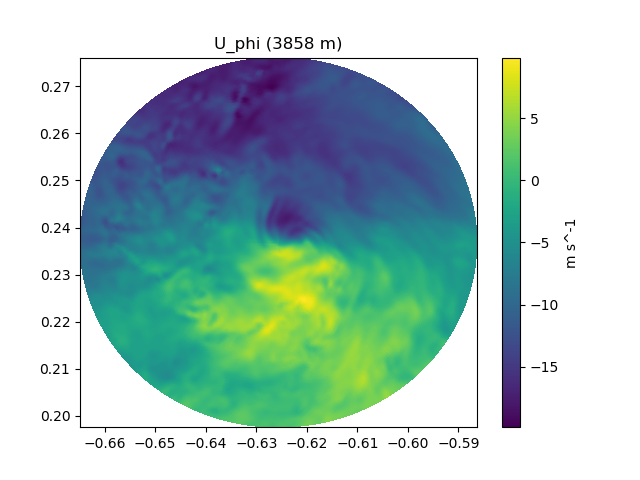

Text(0, 0.5, 'm s^-1')

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.pcolor(fvar_i.x, fvar_i.y, xr.ufuncs.real(fvar_i))
ax.title.set_text('U_phi (%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('m s^-1')
#plt.show()

<IPython.core.display.Javascript object>


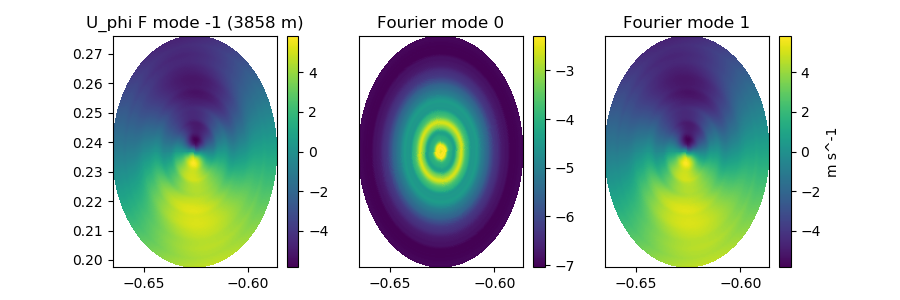

Text(0, 0.5, 'm s^-1')

In [16]:
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(131)
cs = ax.pcolor(fvar_i.x, fvar_i.y, xr.ufuncs.real(fvar_neg1_i))
ax.title.set_text('U_phi F mode -1 (%s m)' %  np.int(lev_height))
cbar = plt.colorbar(cs, ax=ax)

ax = fig.add_subplot(132)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar0_i))
#cs = ax.pcolor(fvar0_i.x, fvar0_i.y, xr.ufuncs.real(fvar_p4_i))
ax.title.set_text('Fourier mode 0')
cbar = plt.colorbar(cs, ax=ax)

ax = fig.add_subplot(133)
ax.axes.get_yaxis().set_visible(False)
cs = ax.pcolor(fvar1_i.x, fvar1_i.y, xr.ufuncs.real(fvar1_i))
ax.title.set_text('Fourier mode 1')
cbar = plt.colorbar(cs, ax=ax)
cbar.ax.set_ylabel('m s^-1')


Ceckout the ratio of the Fourier modes.

In [ ]:
# Calculate maximum value for every mode
fmodes_max = np.empty(len(fvar.k))
fmodes_mean = np.empty(len(fvar.k))
fmodes_min = np.empty(len(fvar.k))

for k in fvar.k.values:
    k = int(k)
    
    fvar_sub = fvar.copy()
    if k == 0:
        fvar_sub[1:] = 0.
    elif k == -1:
        fvar_sub[0:-1]= 0.
    else:
        fvar_sub[0:k] = 0.
        fvar_sub[k+1:] = 0.
    fvar_sub_i = xr.ufuncs.real(polar_idft(fvar_sub))
  
    fmodes_max[k] = fvar_sub_i.max()
    fmodes_min[k] = fvar_sub_i.min()
    fmodes_mean[k] = fvar_sub_i.mean()

In [ ]:
# Plot distribution of max values
sns.set_style("whitegrid")

k_vals = np.concatenate((fvar.k.values[-200:], fvar.k.values[0:202], ))
max_vals = np.concatenate(( fmodes_max[-200:], fmodes_max[0:202]))
min_vals = np.concatenate(( fmodes_min[-200:], fmodes_min[0:202]))

blueish = sns.color_palette("cubehelix", 8)[1]
violetish = sns.color_palette("cubehelix", 8)[5]


fig, ax = plt.subplots(figsize=(5,3))
ax.fill_between(k_vals, 0, max_vals, color=blueish, alpha=.3)
ax.plot(k_vals, max_vals, color=blueish, label="Maxima")
#ax.fill_between(k_vals, 0, min_vals, color=violetish, alpha=.3)
#ax.plot(k_vals, min_vals, color=violetish, label="Minima")

#plt.legend()

plt.title('Maxima of $w_{n1}$')
plt.xlabel('Fourier mode n')
plt.ylabel('Velocity m  s$^{-1}$')

In [ ]:

ds = get_uv_from_polar(ds, center, add_bg=True, bg_wind=bg_wind)